In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import shap
import pickle

In [2]:

import seaborn as sns
import matplotlib.pyplot as plt


from skopt import BayesSearchCV

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

from matplotlib import style
style.use('seaborn') or plt.style.use('seaborn')


def train_model(X_train, y_train, cv):
    param_space = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 5),
        'max_depth': (1, 50),
        'n_estimators': (50, 100),
    }

    # Initialize XGBRegressor
    xgb_reg = xgb.XGBClassifier(objective='binary:logistic')
    opt = BayesSearchCV(
        xgb_reg, param_space, n_iter=10, random_state=0, verbose=0, cv=cv
    )
    opt.fit(X_train, y_train)
    print('Best parameters:', opt.best_params_)
    return opt.best_params_



def XGB_class(X_, y, n_splits, best_params):
    
    from sklearn.model_selection import StratifiedKFold
    feat_imp = []
    feat_shaps = []
    results_df = pd.DataFrame(columns=['y_pred', 'y','index'])
    kf = StratifiedKFold(n_splits=n_splits)

    y_test_list = []
    y_pred_list = []
                                        
    for train_index, test_index in kf.split(X_, y):
        X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = MinMaxScaler((0.05, 0.95))
        scaling_data = scaler.fit_transform(X_train)
        X_s = pd.DataFrame(scaling_data, columns= X_train.columns, index = X_train.index)
        X_train =  X_s.copy()

        scaler = MinMaxScaler((0.05, 0.95))
        scaling_data = scaler.fit_transform(X_test)
        X_s = pd.DataFrame(scaling_data, columns= X_test.columns, index = X_test.index)
        X_test =  X_s.copy()

        model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
        model.fit(X_train, y_train)
        
        y_predict = model.predict_proba(X_test)[:, 1]

        y_test_list.extend(y_test.to_list())
        y_pred_list.extend(list(y_predict))

        result = np.column_stack((y_predict, y_test))

        temp_df = pd.DataFrame(result, columns=['y_pred', 'y'])
        temp_df['index'] = test_index

        results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        feature_importances_dict = {col: importance for col, importance in zip(X_train.columns, model.feature_importances_)}
        feat_imp.append(feature_importances_dict)
        
    fpr, tpr, _ = roc_curve(y_test_list, y_pred_list)
    roc_auc = auc(fpr, tpr)
    results_df = results_df.sort_values('index').reset_index(drop=True)


    scaler = MinMaxScaler((0.05, 0.95))
    scaling_data = scaler.fit_transform(X_)
    X_ = pd.DataFrame(scaling_data, columns= X_.columns, index = X_.index)
    X_ =  X_.copy()

    model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
    model.fit(X_, y)
    
    explainer = shap.Explainer(model, X_)
    feat_shaps = explainer(X_)
        
        

    return (results_df, y_test_list, y_pred_list, feat_imp, feat_shaps)

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [3]:
df = pd.read_excel('Chile_cohort_biomarker.xlsx')
df

,ID,GROUP,Abeta42,Abeta40,GFAP,Nfl,ptau217,Sexo,Edad,Escolaridad,NSE,MoCA,Global cognition,Memory,Attention,Language,Visuospatial,Executive function,Social cognition,Functionality
0,COH_001,COH,4.376692,109.433780,173.905933,23.888774,0.362818,2,75,8,7,28,83,32,93,27,19.5,7.0,23.679,5
1,COH_002,COH,6.995705,100.685049,139.226910,32.164826,0.128184,2,74,0,9,23,63,24,88,25,17.5,16.5,22.393,24
2,COH_004,COH,6.016695,97.950146,129.277040,40.319665,0.311675,2,83,9,5,28,87,36,143,19,35.0,18.0,18.429,11
3,COH_005,COH,5.449759,85.231529,51.482842,20.651383,0.148509,2,79,6,0,21,88,39,80,27,30.0,21.0,13.875,4
4,COH_006,COH,9.082300,161.358352,354.112943,79.787128,0.887083,2,90,8,7,21,69,31,240,24,17.0,13.0,16.661,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,CTR_053,CN,NaN,NaN,NaN,NaN,0.104281,2,74,15,7,27,89,36,59,28,30.0,17.0,27.857,0
357,CTR_054,CN,7.139796,143.196581,202.457129,41.811115,0.139082,2,77,13,10,25,90,28,44,26,35.0,22.0,25.821,0
358,CTR_055,CN,4.774199,101.618336,84.102639,79.778504,0.109089,2,73,18,6,24,91,25,65,27,34.0,23.5,28.446,13
359,CTR_056,CN,6.427548,97.780217,98.430833,21.889528,0.126821,2,78,19,13,28,95,38,42,28,32.0,22.0,25.125,2


In [4]:

def asignar_grupo(row):
    if row['GROUP'] == 'CN':
        return 'CN'
    elif row['GROUP'] == 'AD':
        return 'AD'
    elif row['GROUP'] == 'COH' and row['MoCA'] >= 21:
        return 'QS'
    elif row['GROUP'] == 'COH' and row['MoCA'] < 21:
        return 'DC'
    else:
        return 'ERASE_ME'

df['GROUP2'] = df.apply(asignar_grupo, axis=1)

df


,ID,GROUP,Abeta42,Abeta40,GFAP,Nfl,ptau217,Sexo,Edad,Escolaridad,...,MoCA,Global cognition,Memory,Attention,Language,Visuospatial,Executive function,Social cognition,Functionality,GROUP2
0,COH_001,COH,4.376692,109.433780,173.905933,23.888774,0.362818,2,75,8,...,28,83,32,93,27,19.5,7.0,23.679,5,QS
1,COH_002,COH,6.995705,100.685049,139.226910,32.164826,0.128184,2,74,0,...,23,63,24,88,25,17.5,16.5,22.393,24,QS
2,COH_004,COH,6.016695,97.950146,129.277040,40.319665,0.311675,2,83,9,...,28,87,36,143,19,35.0,18.0,18.429,11,QS
3,COH_005,COH,5.449759,85.231529,51.482842,20.651383,0.148509,2,79,6,...,21,88,39,80,27,30.0,21.0,13.875,4,QS
4,COH_006,COH,9.082300,161.358352,354.112943,79.787128,0.887083,2,90,8,...,21,69,31,240,24,17.0,13.0,16.661,17,QS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,CTR_053,CN,NaN,NaN,NaN,NaN,0.104281,2,74,15,...,27,89,36,59,28,30.0,17.0,27.857,0,CN
357,CTR_054,CN,7.139796,143.196581,202.457129,41.811115,0.139082,2,77,13,...,25,90,28,44,26,35.0,22.0,25.821,0,CN
358,CTR_055,CN,4.774199,101.618336,84.102639,79.778504,0.109089,2,73,18,...,24,91,25,65,27,34.0,23.5,28.446,13,CN
359,CTR_056,CN,6.427548,97.780217,98.430833,21.889528,0.126821,2,78,19,...,28,95,38,42,28,32.0,22.0,25.125,2,CN


In [5]:
df = df[df['GROUP2']!='ERASE_ME']

In [6]:
Counter(df['GROUP2'])

Counter({'QS': 140, 'DC': 111, 'AD': 32, 'CN': 37})

In [7]:
df['GROUP2'].unique()

array(['QS', 'DC', 'AD', 'CN'], dtype=object)

> ## Controles + AD

In [8]:
df_cn_vs = df[(df.GROUP2 == 'CN') | (df.GROUP2 == 'AD')]
df_cn_vs = df_cn_vs.copy()
df_cn_vs['GROUP2'] = df['GROUP2'].map({'CN': 0, 'AD': 1})
df_cn_vs.dropna(inplace=True)
df_cn_vs.reset_index(drop=True, inplace=True)
df_cn_vs['ratio_Ab42_Ab40'] = df_cn_vs['Abeta42']/df_cn_vs['Abeta40'] 
df_cn_vs.shape


(55, 22)

In [9]:
X = df_cn_vs[[ 'Abeta42', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']

n_splits = 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)

dict_y = {}
dict_y['Abeta42'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.05483703374321857), ('max_depth', 23), ('min_child_weight', 1), ('n_estimators', 90)])


In [10]:
X = df_cn_vs[[ 'Abeta40', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['Abeta40'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.05483703374321857), ('max_depth', 23), ('min_child_weight', 1), ('n_estimators', 90)])


In [11]:
X = df_cn_vs[[ 'GFAP', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['GFAP'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.11412570783544687), ('max_depth', 4), ('min_child_weight', 2), ('n_estimators', 60)])


In [12]:
X = df_cn_vs[[ 'Nfl', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['Nfl'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.05483703374321857), ('max_depth', 23), ('min_child_weight', 1), ('n_estimators', 90)])


In [13]:
X = df_cn_vs[[ 'ptau217', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['ptau217'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.11532629231795405), ('max_depth', 34), ('min_child_weight', 3), ('n_estimators', 82)])


In [14]:
X = df_cn_vs[[ 'Nfl', 'GFAP', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['Nfl_GFAP'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.11412570783544687), ('max_depth', 4), ('min_child_weight', 2), ('n_estimators', 60)])


In [15]:
X = df_cn_vs[[ 'Nfl', 'ptau217', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['Nfl_ptau217'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.11532629231795405), ('max_depth', 34), ('min_child_weight', 3), ('n_estimators', 82)])


In [16]:
X = df_cn_vs[[ 'ratio_Ab42_Ab40', 'Escolaridad', 'Edad', 'Sexo']]#, 'Age_moderate_Educ']]
y = df_cn_vs['GROUP2']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
best_params = train_model(X_train, y_train, n_splits)


[results, y_test_list, y_pred_list, feat_imp, shap_values] = XGB_class(X, y, n_splits, best_params)


dict_y['ratio_Ab42_Ab40'] = [y_test_list, y_pred_list, feat_imp, shap_values]

Best parameters: OrderedDict([('learning_rate', 0.05483703374321857), ('max_depth', 23), ('min_child_weight', 1), ('n_estimators', 90)])


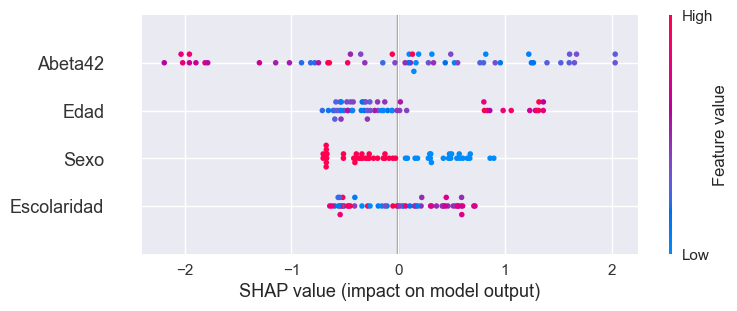

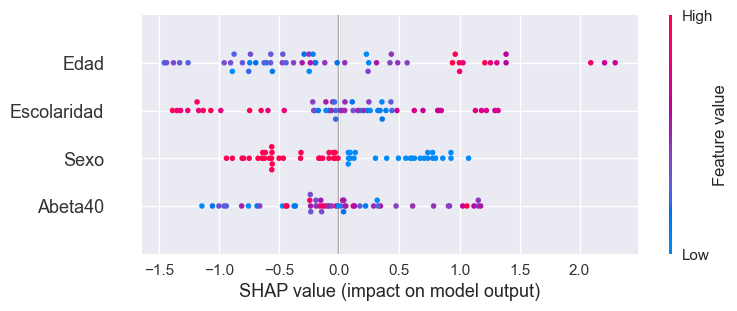

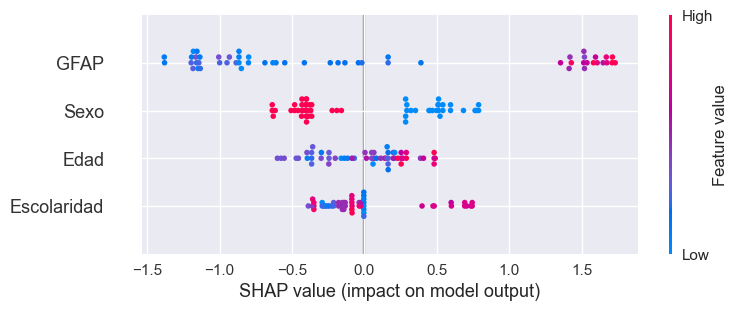

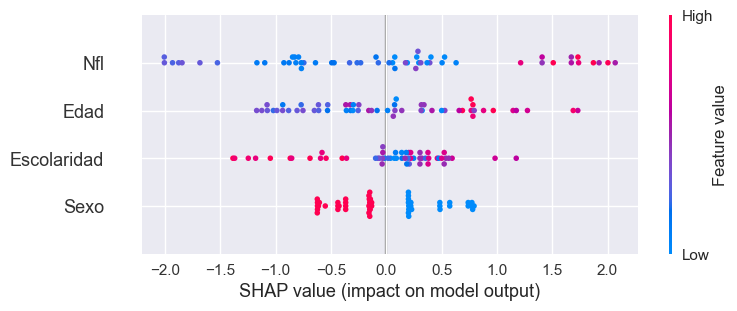

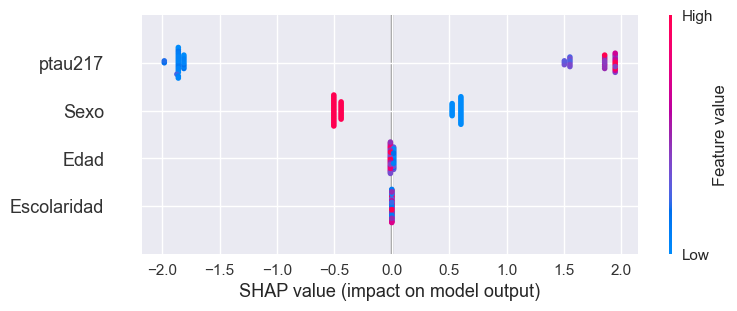

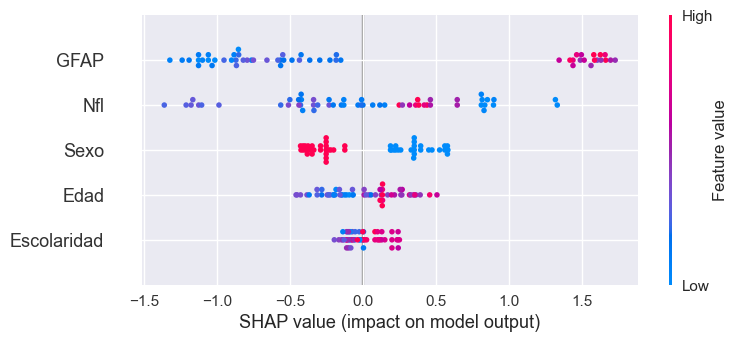

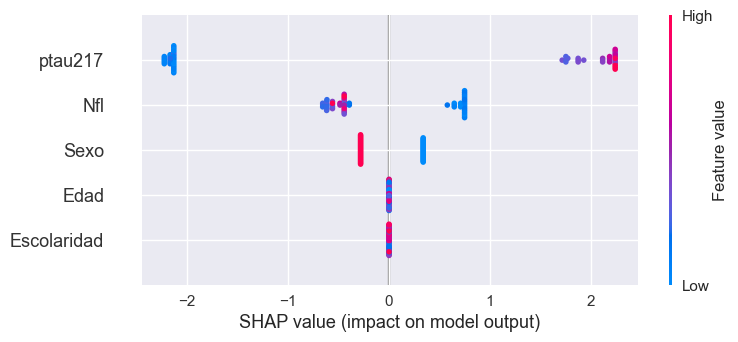

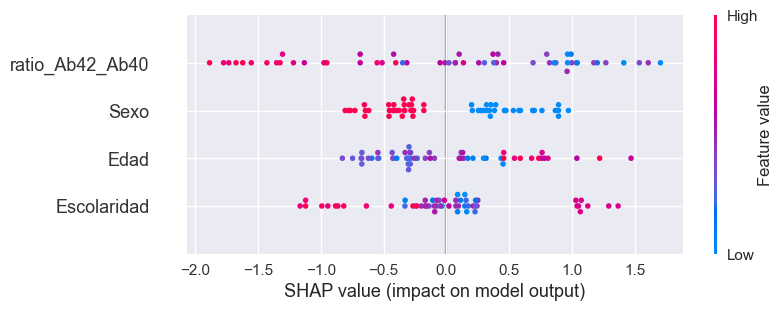

In [18]:
for i in list(dict_y.keys()):
    plt.figure()
    shap.plots.beeswarm(dict_y[i][-1], show=False)
    plt.savefig('Results/CN_AD/Biomarkers+demog/CN_AD_shaps_beeswarm_' + i +'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

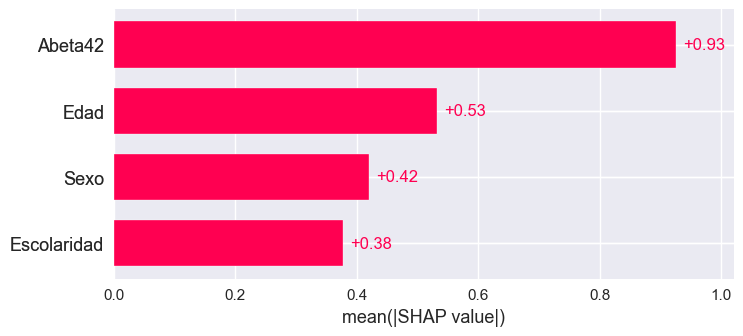

In [11]:
for i in list(dict_y.keys()):
    plt.figure()
    shap.plots.bar(dict_y[i][-1], show=False)
    plt.savefig('Results/CN_AD/Biomarkers+demog/CN_AD_shaps_abs_bar_' + i +'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [33]:
shap_values.feature_names

['Abeta42', 'Escolaridad', 'Edad', 'Sexo']

In [32]:
np.abs(shap_values.values[:,1]).mean()

0.37805953540616044

In [28]:
X.columns

Index(['Abeta42', 'Escolaridad', 'Edad', 'Sexo'], dtype='object')

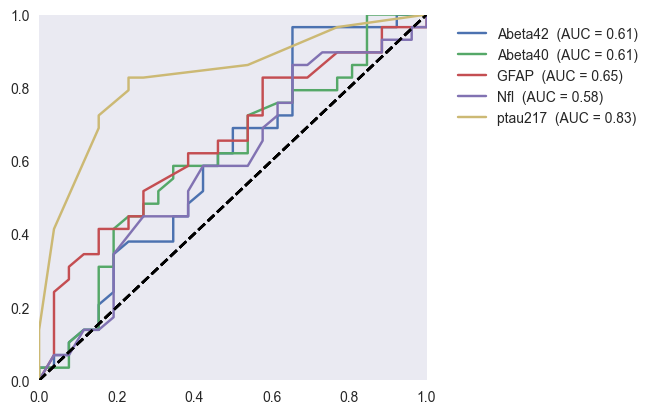

In [20]:
plt.figure(figsize=(5,4.75))

for i in list(dict_y.keys())[0:5]:
    name = i
    fpr, tpr, _ = roc_curve(dict_y[i][0], dict_y[i][1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name:s}  (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('Results/CN_AD/Biomarkers+demog/CN_AD_ROCs_01.pdf', format='pdf', bbox_inches='tight')

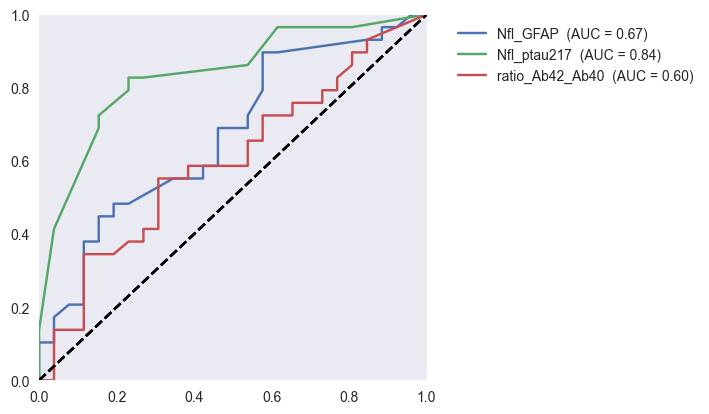

In [28]:
plt.figure(figsize=(5,4.75))

for i in list(dict_y.keys())[5::]:
    name = i
    fpr, tpr, _ = roc_curve(dict_y[i][0], dict_y[i][1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name:s}  (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('Results/CN_AD/Biomarkers+demog/CN_AD_ROCs_02.pdf', format='pdf', bbox_inches='tight')

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#
## Supongamos que dict_y[i][0] son las etiquetas reales y dict_y[i][1] son las probabilidades predichas
#etiquetas_reales = dict_y[i][0]
#probabilidades_predichas = dict_y[i][1]
#
## Crear un DataFrame con las etiquetas y probabilidades
#data = {'Etiquetas Reales': etiquetas_reales, 'Probabilidades Predichas': probabilidades_predichas}
#df = pd.DataFrame(data)
#
## Separar las probabilidades para clases positivas y negativas
#probabilidades_positivas = df.loc[df['Etiquetas Reales'] == 1, 'Probabilidades Predichas']
#probabilidades_negativas = df.loc[df['Etiquetas Reales'] == 0, 'Probabilidades Predichas']
#
## Crear subgráficos (subplots) con seaborn
#fig, axs = plt.subplots(1, 2, figsize=(8, 4))
#
## Subplot para clase negativa
#sns.histplot(probabilidades_negativas, element='step', stat='density', color='blue', label='Clase Negativa', alpha=0.7, ax=axs[0], bins=20)
#axs[0].set_xlabel('Probabilidades Predichas')
#axs[0].set_ylabel('Densidad')
#axs[0].legend(title='Clase Negativa')
#axs[0].grid(False)
#
## Subplot para clase positiva
#sns.histplot(probabilidades_positivas, element='step', stat='density', color='green', label='Clase Positiva', alpha=0.7, ax=axs[1], bins=20)
#axs[1].set_xlabel('Probabilidades Predichas')
#axs[1].set_ylabel('Densidad')
#axs[1].legend(title='Clase Positiva')
#axs[1].grid(False)
## Ajustar diseño y mostrar los subgráficos
#plt.tight_layout()
#plt.show()



In [30]:
import warnings
warnings.filterwarnings("ignore")

df_metrics_05_data = []

for i in list(dict_y.keys()):
    name = i
    fpr, tpr, _ = roc_curve(dict_y[i][0], dict_y[i][1])
    roc_auc = auc(fpr, tpr)
    
    y_pred_rounded = np.where(np.array(dict_y[i][1]) > 0.5, 1, 0)

    f1 = f1_score(dict_y[i][0], y_pred_rounded)
    accuracy = accuracy_score(dict_y[i][0], y_pred_rounded)
    recall = recall_score(dict_y[i][0], y_pred_rounded)
    precision = precision_score(dict_y[i][0], y_pred_rounded)

    # Calcular NPV (Negative Predictive Value) para la clase 0
    cm = confusion_matrix(dict_y[i][0], y_pred_rounded)
    tn = cm[0, 0]
    fn = cm[1, 0]
    
    # Calcular NPV (Negative Predictive Value)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metric_dict = {
        'Name': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Recall': recall,
        'Specificity': specificity,
        'NPV': npv
    }
    
    df_metrics_05_data.append(metric_dict)

df_metrics_05 = pd.DataFrame(df_metrics_05_data)

df_metrics_05

,Name,AUC,Accuracy,Precision,F1 Score,Recall,Specificity,NPV
0,Abeta42,0.607427,0.600000,0.606061,0.645161,0.689655,0.500000,0.590909
1,Abeta40,0.609416,0.581818,0.588235,0.634921,0.689655,0.461538,0.571429
2,GFAP,0.652520,0.563636,0.575758,0.612903,0.655172,0.461538,0.545455
3,Nfl,0.584218,0.563636,0.567568,0.636364,0.724138,0.384615,0.555556
4,ptau217,0.829576,0.781818,0.840000,0.777778,0.724138,0.846154,0.733333
5,Nfl_GFAP,0.671088,0.581818,0.600000,0.610169,0.620690,0.538462,0.560000
6,Nfl_ptau217,0.836870,0.781818,0.840000,0.777778,0.724138,0.846154,0.733333
7,ratio_Ab42_Ab40,0.599469,0.545455,0.552632,0.626866,0.724138,0.346154,0.529412


In [23]:
import warnings
warnings.filterwarnings("ignore")

df_metrics_06_data = []

for i in list(dict_y.keys()):
    name = i
    fpr, tpr, _ = roc_curve(dict_y[i][0], dict_y[i][1])
    roc_auc = auc(fpr, tpr)
    
    y_pred_rounded = np.where(np.array(dict_y[i][1]) > 0.6, 1, 0)

    f1 = f1_score(dict_y[i][0], y_pred_rounded)
    accuracy = accuracy_score(dict_y[i][0], y_pred_rounded)
    recall = recall_score(dict_y[i][0], y_pred_rounded)
    precision = precision_score(dict_y[i][0], y_pred_rounded)

    # Calcular NPV (Negative Predictive Value) para la clase 0
    cm = confusion_matrix(dict_y[i][0], y_pred_rounded)
    tn = cm[0, 0]
    fn = cm[1, 0]
    
    # Calcular NPV (Negative Predictive Value)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metric_dict = {
        'Name': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Recall': recall,
        'Specificity': specificity,
        'NPV': npv
    }
    
    df_metrics_06_data.append(metric_dict)

df_metrics_06 = pd.DataFrame(df_metrics_06_data)


In [24]:
import warnings
warnings.filterwarnings("ignore")

df_metrics_07_data = []

for i in list(dict_y.keys()):
    name = i
    fpr, tpr, _ = roc_curve(dict_y[i][0], dict_y[i][1])
    roc_auc = auc(fpr, tpr)
    
    y_pred_rounded = np.where(np.array(dict_y[i][1]) > 0.7, 1, 0)

    f1 = f1_score(dict_y[i][0], y_pred_rounded)
    accuracy = accuracy_score(dict_y[i][0], y_pred_rounded)
    recall = recall_score(dict_y[i][0], y_pred_rounded)
    precision = precision_score(dict_y[i][0], y_pred_rounded)

    # Calcular NPV (Negative Predictive Value) para la clase 0
    cm = confusion_matrix(dict_y[i][0], y_pred_rounded)
    tn = cm[0, 0]
    fn = cm[1, 0]
    
    # Calcular NPV (Negative Predictive Value)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metric_dict = {
        'Name': name,
        'AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Recall': recall,
        'Specificity': specificity,
        'NPV': npv
    }
    
    df_metrics_07_data.append(metric_dict)

df_metrics_07 = pd.DataFrame(df_metrics_07_data)


In [26]:
with pd.ExcelWriter('Results/CN_AD/Biomarkers+demog/CN_AD_metrics.xlsx', engine='xlsxwriter') as writer:
    # Guardar cada DataFrame en una hoja diferente
    df_metrics_05.to_excel(writer, sheet_name='threshold_05', index=False)
    df_metrics_06.to_excel(writer, sheet_name='threshold_06', index=False)
    df_metrics_07.to_excel(writer, sheet_name='threshold_07', index=False)


In [27]:
df_metrics_07

,Name,AUC,Accuracy,Precision,F1 Score,Recall,Specificity,NPV
0,Abeta42,0.607427,0.527273,0.571429,0.480000,0.413793,0.653846,0.500000
1,Abeta40,0.609416,0.581818,0.636364,0.549020,0.482759,0.692308,0.545455
2,GFAP,0.652520,0.600000,0.629630,0.607143,0.586207,0.615385,0.571429
3,Nfl,0.584218,0.563636,0.600000,0.555556,0.517241,0.615385,0.533333
4,ptau217,0.829576,0.781818,0.840000,0.777778,0.724138,0.846154,0.733333
5,Nfl_GFAP,0.671088,0.618182,0.700000,0.571429,0.482759,0.769231,0.571429
6,Nfl_ptau217,0.836870,0.781818,0.840000,0.777778,0.724138,0.846154,0.733333
7,ratio_Ab42_Ab40,0.599469,0.545455,0.566667,0.576271,0.586207,0.500000,0.520000
